In [31]:
import torch
import numpy as np
from scipy.optimize import minimize_scalar

###############################################################################
# 0. 全体設定
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("使用デバイス:", device)

n = 8            # 消費者が使用する期間           
aU = 0.7         # 中古品の満足度の割引率
aS = 0.9         # サブスクリプションの満足度の割引率
cN = 0.5         # 新品のコスト
cU = 0.3         # 中古品のコスト
cSub = 0.05      # サブスクリプションの毎期コスト

# --------------------------------------------------------------------------
   

R = 0.95         # サブスクの生産者の利益の割引率

price_min = 0.0     # 価格の下限
price_max = 1.0     # 価格の上限
num_samples = 500000  # 需要計算時のランダムサンプル数
max_iter = 400      # 反復回数の最大値
tol = 1e-3          # 収束の許容誤差

# r_min, r_max 定義
r_min = 0.5
r_max = 0.95

# 固定ランダムシード（再現性のため）
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# --------------------------------------------------------------------------
# β を導入：サブ企業が新品企業から仕入れる時の単価に乗じる係数
# 例えば β=0.2 として、"1ユニットあたり pN のうち 20% を仕入れコストとして支払う" などを想定
# --------------------------------------------------------------------------
beta = 1

###############################################################################
# 1. 効用関数
###############################################################################
def u_new_torch(w, r, pN):
    if pN is None or pN <= 0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n) / (1 - r_clamp)
    return w * term - pN

def u_used_torch(w, r, pU):
    if pU is None or pU <= 0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n) / (1 - r_clamp)
    return aU * w * term - pU

def u_sub_torch(w, r, pSub):
    if pSub is None or pSub <= 0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n) / (1 - r_clamp)
    return aS * (w - pSub) * term

###############################################################################
# 2. 需要関数 (不生产时需求=0)
###############################################################################
def demand_new(pN, pU, pSub):
    if pN is None or pN <= 0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un < 0) & (uu < 0) & (us < 0)
    new_mask = (un >= uu) & (un >= us) & (~no_mask)
    return new_mask.float().mean().item()

def demand_used(pN, pU, pSub):
    if pU is None or pU <= 0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un < 0) & (uu < 0) & (us < 0)
    used_mask = (uu >= un) & (uu >= us) & (~no_mask)
    return used_mask.float().mean().item()

def demand_sub(pN, pU, pSub):
    if pSub is None or pSub <= 0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un < 0) & (uu < 0) & (us < 0)
    sub_mask = (us >= un) & (us >= uu) & (~no_mask)
    return sub_mask.float().mean().item()

def demand_no(pN, pU, pSub):
    """
    不消費を選ぶ確率
    """
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min) * torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un < 0) & (uu < 0) & (us < 0)
    return no_mask.float().mean().item()

###############################################################################
# 3. 利潤関数: 若选择不生产 => 利润=0
###############################################################################
def profit_new(pN, pU, pSub):
    """
    新品企業の利益:
      - 基本的には D_new * (pN - cN)
      - サブ企業から仕入れ分 (D_sub * pN * β) も追加収入として加算する
    """
    if pN is None:
        return 0.0
    dN = demand_new(pN, pU, pSub)
    dS = demand_sub(pN, pU, pSub)

    if dN == 0 and dS == 0:
        return 0.0

    # 新品販売による利益
    pi_new_basic = dN * (pN - cN)
    # サブ企業への供給による追加収入
    pi_new_from_sub = dS * pN * beta

    return pi_new_basic + pi_new_from_sub

def profit_used(pN, pU, pSub):
    """
    中古企業の利益:
      - 需要が 0 の場合や pU = inf の場合は 0
    """
    if pU == float('inf'):
        return 0.0
    dU = demand_used(pN, pU, pSub)
    if dU == 0:
        return 0.0
    return dU * (pU - cU)

def profit_sub(pN, pU, pSub):
    """
    サブスクリプション企業の利益:
      - 基本: D_sub * (pSub - cSub) * discount_factor
      - ただし, 新品企業から仕入れ (コスト) = D_sub * pN * β を支払う
      - 結果: 利潤 = [ D_sub * (pSub - cSub) * discount_factor ] - [ D_sub * pN * β ]
    """
    if pSub == float('inf'):
        return 0.0
    dS = demand_sub(pN, pU, pSub)
    if dS == 0:
        return 0.0

    discount_factor = (1 - R**n) / (1 - R) if abs(1 - R) > 1e-12 else n

    # サブ企業の基本収入
    pi_sub_basic = dS * (pSub - cSub) * discount_factor
    # 新品企業への支払い
    cost_pay_to_new = dS * pN * beta

    return pi_sub_basic - cost_pay_to_new

###############################################################################
# 4. 最適反応関数：若最大利润<0 => 不生产
###############################################################################
def best_response_new(pU, pS):
    """
    新品企業の最適価格を計算:
      - まず minimize_scalar で最大利潤を探索
      - その最大利潤が <= 0 の場合、不生産(価格=None, profit=0) とする
    """
    res = minimize_scalar(
        lambda pN: -profit_new(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pN = res.x
    best_profit = -res.fun  # 最大化 -> -res.fun

    if best_profit <= 0:
        return None
    else:
        return best_pN

def best_response_used(pN, pS):
    """
    中古企業の最適価格
    """
    res = minimize_scalar(
        lambda pU: -profit_used(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pU = res.x
    best_profit = -res.fun
    if best_profit <= 0:
        return None
    else:
        return best_pU

def best_response_sub(pN, pU):
    """
    サブ企業の最適価格
    """
    res = minimize_scalar(
        lambda pS: -profit_sub(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pS = res.x
    best_profit = -res.fun
    if best_profit <= 0:
        return None
    else:
        return best_pS

###############################################################################
# 5. 均衡価格の探索
###############################################################################
def find_equilibrium_prices(pN_init=0.7, pU_init=0.5, pS_init=0.3):
    """
    すべての企業が最適反応を繰り返し調整し、均衡価格を見つける。
    ただし、企業が最大利潤 <= 0 の場合、その企業の価格は "無限大" に設定され、市場から退出する。
    """
    alpha = 0.1  # ダンピング（緩和）係数
    pN, pU, pS = pN_init, pU_init, pS_init

    for i in range(max_iter):
        oldN, oldU, oldS = pN, pU, pS

        # 各企業の最適反応価格を計算
        new_pN = best_response_new(oldU, oldS)
        new_pU = best_response_used(new_pN, oldS)
        new_pS = best_response_sub(new_pN, new_pU)

        # 利潤 <= 0 の場合、企業は退出 (価格=inf)
        if new_pN is None or profit_new(new_pN, oldU, oldS) <= 0:
            new_pN = float('inf')
        if new_pU is None or profit_used(oldN, new_pU, oldS) <= 0:
            new_pU = float('inf')
        if new_pS is None or profit_sub(oldN, oldU, new_pS) <= 0:
            new_pS = float('inf')

        # 退出した企業は価格 inf のまま、継続なら緩和更新
        pN = new_pN if new_pN == float('inf') else (alpha * new_pN + (1 - alpha) * oldN)
        pU = new_pU if new_pU == float('inf') else (alpha * new_pU + (1 - alpha) * oldU)
        pS = new_pS if new_pS == float('inf') else (alpha * new_pS + (1 - alpha) * oldS)

        # 収束判定 (inf は距離計算から除外)
        dist = sum([
            ((pN - oldN)**2 if pN != float('inf') else 0),
            ((pU - oldU)**2 if pU != float('inf') else 0),
            ((pS - oldS)**2 if pS != float('inf') else 0)
        ])**0.5

        if dist < tol:
            print(f"収束した (Iter {i+1})")
            return pN, pU, pS

    print(f"警告: {max_iter}回に達しましたが収束しません。")
    print(f"最終: pN={pN}, pU={pU}, pS={pS}")
    return pN, pU, pS

###############################################################################
# 6. 需要と利潤の表示
###############################################################################
def show_demands_and_profits(pN, pU, pS):
    """
    各企業の需要量と利潤を表示する
    """
    dN = demand_new(pN, pU, pS)
    dU = demand_used(pN, pU, pS)
    dS = demand_sub(pN, pU, pS)
    dNo = demand_no(pN, pU, pS)

    piN = profit_new(pN, pU, pS)
    piU = profit_used(pN, pU, pS)
    piS = profit_sub(pN, pU, pS)

    print("需要量:")
    print(f"  D_new  = {dN:.4f}")
    print(f"  D_used = {dU:.4f}")
    print(f"  D_sub  = {dS:.4f}")
    print(f"  D_no   = {dNo:.4f}")
    print(f"  合計    = {dN + dU + dS + dNo:.4f}")

    print("利潤:")
    print(f"  profit_new  = {piN:.4f}")
    print(f"  profit_used = {piU:.4f}")
    print(f"  profit_sub  = {piS:.4f}")

# ------------------------------------------------------------------------------
# サンプル実行例
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    # 初期価格設定
    pN_init = 0.7
    pU_init = 0.5
    pS_init = 0.3

    # 均衡価格の探索
    eq_pN, eq_pU, eq_pS = find_equilibrium_prices(pN_init, pU_init, pS_init)
    print("求められた均衡価格:")
    print(f"  pN = {eq_pN}")
    print(f"  pU = {eq_pU}")
    print(f"  pS = {eq_pS}")

    # 需要と利潤の表示
    print("\n--- 需要と利潤 ---")
    show_demands_and_profits(eq_pN, eq_pU, eq_pS)

収束した (Iter 30)
求められた均衡価格:
  pN = 0.9838250908439329
  pU = 0.45622363122277143
  pS = 0.29360443237129275

--- 需要と利潤 ---
需要量:
  D_new  = 0.3680
  D_used = 0.2033
  D_sub  = 0.2313
  D_no   = 0.1984
  合計    = 1.0010
利潤:
  profit_new  = 0.4045
  profit_used = 0.0318
  profit_sub  = 0.1520


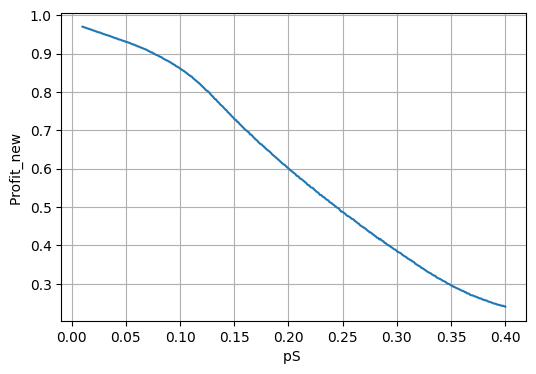

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dN_vs_pS(pN_fixed=0.9, pU_fixed=0.4, pS_start=0.01, pS_end=0.4, num_points=400):
    """
    pN_fixed:  固定的新产品价格
    pU_fixed:  固定的二手产品价格
    pS_start:  pS 取值的起始
    pS_end:    pS 取值的终止
    num_points: 取点数量
    """
    pS_values = np.linspace(pS_start, pS_end, num_points)
    figure_values = []

    for pS in pS_values:
        figN = profit_new(pN_fixed, pU_fixed, pS)
        figure_values.append(figN)

    plt.figure(figsize=(6,4))
    plt.plot(pS_values, figure_values, marker='', linestyle='-')
    plt.xlabel("pS ")
    plt.ylabel("Profit_new ")
    #plt.title(f" D_new and pS\n(pN={pN_fixed}, pU={pU_fixed})")
    plt.grid(True)
    plt.show()

# 例: 在主程序最后添加并调用
if __name__ == "__main__":
    pN_init = 0.98
    pU_init = 0.45
    plot_dN_vs_pS(pN_fixed=pN_init, pU_fixed=pU_init)